In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = 'cyan'
f_dict = {'size':16}

In [3]:
#18.1 Multiple Linear Regression
#data
df = pd.read_csv('data/Guber1999data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
State        50 non-null object
Spend        50 non-null float64
StuTeaRat    50 non-null float64
Salary       50 non-null float64
PrcntTake    50 non-null int64
SATV         50 non-null int64
SATM         50 non-null int64
SATT         50 non-null int64
dtypes: float64(3), int64(4), object(1)
memory usage: 3.2+ KB


In [4]:
df.head()

,State,Spend,StuTeaRat,Salary,PrcntTake,SATV,SATM,SATT
0,Alabama,4.405,17.2,31.144,8,491,538,1029
1,Alaska,8.963,17.6,47.951,47,445,489,934
2,Arizona,4.778,19.3,32.175,27,448,496,944
3,Arkansas,4.459,17.1,28.934,6,482,523,1005
4,California,4.992,24.0,41.078,45,417,485,902


In [5]:
X = df[['Spend', 'PrcntTake']]
y = df['SATT']

meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

meany = y.mean()
scaley = y.std()
zy = ((y-meany)/scaley).values

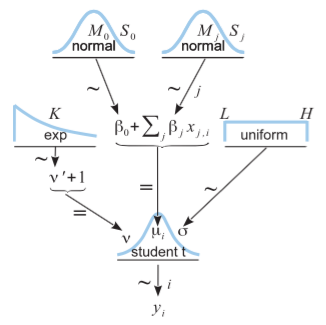

In [7]:
#model
Image('images/fig18_4.png', width=400)

In [8]:
with pm.Model() as model:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pm.Normal('zbetaj', mu=0, sd=2, shape=(2))
    zmu =  zbeta0 + pm.math.dot(zbetaj, zX.T)
        
    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

In [9]:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [zsigma, nu, zbetaj, zbeta0]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:20<00:00, 1035.00draws/s]


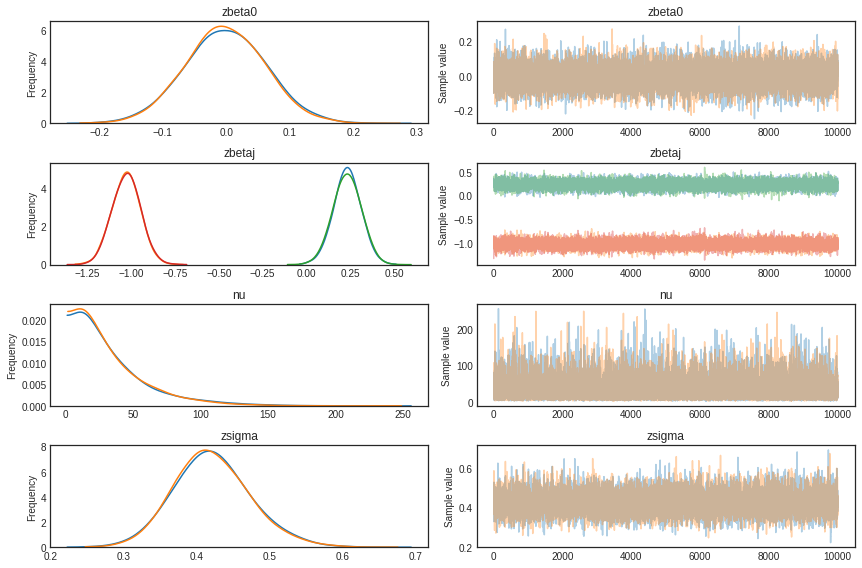

In [10]:
pm.traceplot(trace);

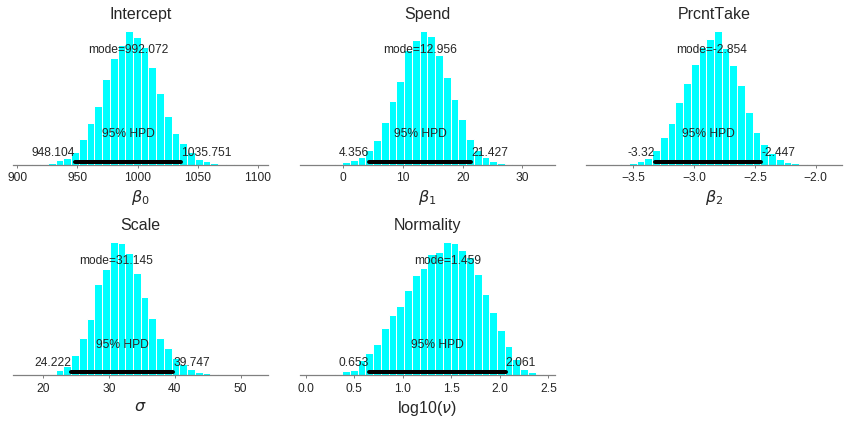

In [11]:
#fig 18.5
burnin = 100
beta0 = trace['zbeta0']*scaley + meany - np.sum(trace['zbetaj']*meanx/scalex, axis=1)*scaley
betaj = (trace['zbetaj']/scalex)*scaley
scale = (trace['zsigma']*scaley)[burnin:]

intercept = beta0[burnin:]
spend = betaj[:,0][burnin:]
prcnttake =  betaj[:,1][burnin:]
normality = np.log10(trace['nu'][burnin:])

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2,3, figsize=(12,6))

for ax, estimate, title, xlabel in zip(fig.axes,
                               [intercept, spend, prcnttake, scale, normality],
                               ['Intercept', 'Spend', 'PrcntTake', 'Scale', 'Normality'],
                               [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$', r'$\sigma$', r'log10($\nu$)']):
    pm.plot_posterior(estimate, point_estimate='mode', ax=ax, color=color)
    ax.set_title(title, fontdict=f_dict)
    ax.set_xlabel(xlabel, fontdict=f_dict)

fig.tight_layout()
ax6.set_visible(False)

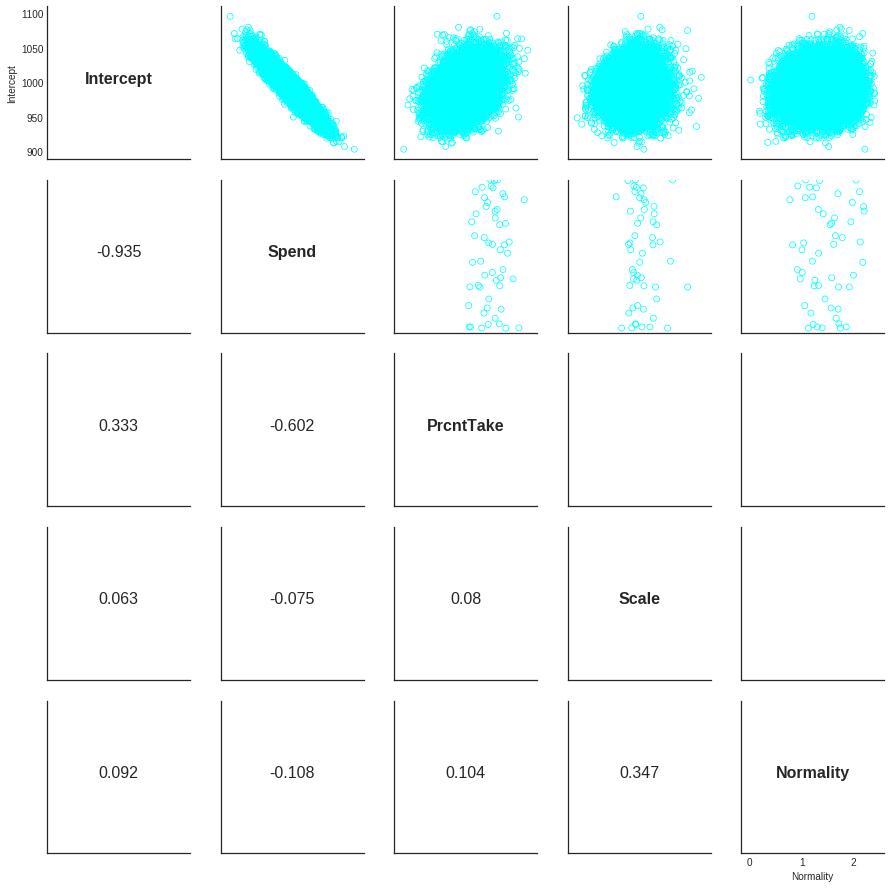

In [12]:
# DataFrame with the columns in correct order
pair_plt = pd.DataFrame({'Intercept':intercept,
                         'Spend':spend,
                         'PrcntTake': prcnttake,
                         'Scale':scale,
                         'Normality': normality},
                        columns=['Intercept', 'Spend', 'PrcntTake', 'Scale', 'Normality'])

# Correlation coefficients
corr = np.round(np.corrcoef(pair_plt, rowvar=0), decimals=3)
# Indexes of the lower triangle, below the diagonal
lower_idx = np.tril(corr, -1).nonzero()

# The seaborn pairplot
pgrid = sns.pairplot(pair_plt, plot_kws={'edgecolor':color, 'facecolor':'none'})

# Replace the plots on the diagonal with the parameter names
for i, ax in enumerate(pgrid.diag_axes):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, pair_plt.columns[i], transform=ax.transAxes, fontdict={'size':16, 'weight':'bold'}, ha='center') 

# Replace the lower triangle with the correlation coefficients
for i, ax in enumerate(pgrid.axes[lower_idx]):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, corr[lower_idx][i], transform=ax.transAxes, fontdict=f_dict, ha='center')

In [13]:
#18.1.4 Redundant Predictors
X2 = X.assign(PropNotTake = lambda x: (100-x.PrcntTake)/100)

meanx2 = X2.mean().values
scalex2 = X2.std().values
zX2 = ((X2-meanx2)/scalex2).values

In [14]:
with pm.Model() as model2:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pm.Normal('zbetaj', mu=0, sd=2, shape=(3))
    zmu =  zbeta0 + pm.math.dot(zbetaj, zX2.T)
        
    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

In [15]:
with model2:
    trace2 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [zsigma, nu, zbetaj, zbeta0]
Sampling 2 chains: 100%|██████████| 11000/11000 [01:30<00:00, 121.02draws/s]


In [ ]:
pm.traceplot(trace2);